<a href="https://colab.research.google.com/github/agosto-jaredburns/clustering-air-quality/blob/master/Clustering_Global_Air_Quality_with_BigQuery_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from bq_helper import BigQueryHelper
from google.cloud import bigquery
import datetime
from google.colab import files
from IPython.display import Image
import folium
from branca.element import Template, MacroElement
project_id = 'agosto-sandbox-jaredburns'
client = bigquery.Client(project=project_id)

# Feature Engineering with SQL
## Part 1: Entity Extraction - Global Cities
#### This query shows how to leverage SQL to assign smaller cities to nearby larger cities and how to associate cities with site locations using BigQuery GIS functions. The following steps summarize the subqueries:
1. Load the worldcities.csv file downloaded from https://simplemaps.com/data/world-cities to BigQuery. This data contains city location with population statistics. First subquery filters to only incorporate cities with a valid population amount.
2. Self join the population table to find smaller cities within a 50 mile radius of a larger city (e.g. Hong Kong to Shenzhen)
3. Join the table with smaller cities within close proximity and add a new column called "master_city" which is the primary city. Smaller cities within 50 miles will be excluded from analysis.
4. From the 'openaq' dataset, find all air quality site locations within 50 miles of cities. Create a lookup table to associate cities with air quality sites within 50 miles
5. Pull the 95th percentile of air quality data for sites within 50 miles of large cities.
6. The final table will have all cities with air quality data. ValidAQ is a column that counts how many non-missing air quality parameters there are in the final table.

In [49]:
%%bigquery --project $project_id
CREATE OR REPLACE TABLE
  SANDBOX.global_air_quality AS
  -- Population table loaded from https://simplemaps.com/data/world-cities
WITH
  population AS (
  SELECT
    city,
    city_ascii,
    lat,
    lng,
    country,
    iso2,
    iso3,
    admin_name,
    capital,
    population,
    id,
    ROW_NUMBER() OVER (ORDER BY population DESC) AS pop_rank --Rank cities by population
  FROM
    SANDBOX.world_cities_population 
  WHERE
    population IS NOT NULL ),
  -- Self join the population table to find smaller cities within a 50 mile radius of a larger city (e.g. Hong Kong and Shenzhen) 
  secondary_cities AS (
  SELECT
    pop1.city AS master_city,
    pop1.country AS master_country,
    pop1.pop_rank AS master_pop_rank,
    pop1.admin_name AS master_admin_name,
    pop2.city AS secondary_city,
    pop2.country AS secondary_country,
    pop2.pop_rank AS secondary_pop_rank,
    pop2.admin_name AS secondary_admin_name,
    ROW_NUMBER() OVER (PARTITION BY pop2.city, pop2.country, pop2.admin_name ORDER BY pop1.pop_rank) AS master_ind --Indicator to assign secondary cities to the largest master city
  FROM
    population pop1,
    population pop2
  WHERE
    ST_DWithin( ST_GeogPoint(pop1.lng,
        pop1.lat),
      ST_GeogPoint(pop2.lng,
        pop2.lat),
      50*1609.34) --1,609 meters per mile and multiply by 50 
    AND pop1.pop_rank < pop2.pop_rank ),

  -- Join the table with smaller cities within close proximity and add a new column called "master_city" which is the primary city. Smaller cities within 50 miles will be excluded from analysis.
  masterlist AS (
  SELECT
    population.city,
    population.city_ascii,
    population.lat,
    population.lng,
    population.country,
    population.iso2,
    population.iso3,
    population.admin_name,
    population.capital,
    population.population,
    population.id,
    population.pop_rank,
    ROW_NUMBER() OVER (PARTITION BY population.country ORDER BY population.population DESC) AS country_pop_rank,
    sec_cities.master_city
  FROM
    population
  LEFT JOIN (
    SELECT
      *
    FROM
      secondary_cities
    WHERE
      master_ind=1) sec_cities
  ON
    population.city=sec_cities.secondary_city
  AND 
    population.country=sec_cities.secondary_country
  AND 
    population.admin_name=sec_cities.secondary_admin_name
    ),

  -- Pull the 95th percentile of air quality data for sites within 50 miles of large cities
  pollutants AS (
  SELECT
    city,
    country,
    admin_name,
    MAX(CASE
        WHEN pollutant = 'co' THEN Value95
    END
      ) AS MaxValue_co,
    MAX(CASE
        WHEN pollutant = 'no2' THEN Value95
    END
      ) AS MaxValue_no2,
    MAX(CASE
        WHEN pollutant = 'o3' THEN Value95
    END
      ) AS MaxValue_o3,
    MAX(CASE
        WHEN pollutant = 'pm25' THEN Value95
    END
      ) AS MaxValue_pm25,
    MAX(CASE
        WHEN pollutant = 'so2' THEN Value95
    END
      ) AS MaxValue_so2
  FROM (
    SELECT
      masterlist.city,
      masterlist.country,
      masterlist.admin_name,
      sites.pollutant,
      PERCENTILE_CONT(sites.value,
        0.99) OVER (PARTITION BY masterlist.city, masterlist.country, masterlist.admin_name, sites.pollutant) AS Value95
    FROM
      masterlist, 
        `bigquery-public-data.openaq.global_air_quality` sites
    WHERE
      ST_DWithin( ST_GeogPoint(sites.longitude,
          sites.latitude),
        ST_GeogPoint(masterlist.lng,
          masterlist.lat),
        50*1609.34)
    and
      EXTRACT(year
        FROM
          sites.timestamp) = 2019
    AND 
      EXTRACT(month
        FROM
          sites.timestamp) = 9
    AND 
      sites.value > 0
    AND 
      sites.averaged_over_in_hours = 1
    )
  GROUP BY
    1,
    2,
    3)
  
-- The final table will have all cities with air quality data. ValidAQ is a column that counts how many non-missing air quality parameters there are
SELECT
  masterlist.*,
  pollutants.MaxValue_co,
  pollutants.MaxValue_no2,
  pollutants.MaxValue_o3,
  pollutants.MaxValue_pm25,
  pollutants.MaxValue_so2,
  (
  IF
    (pollutants.MaxValue_co IS NOT NULL,
      1,
      0)+
  IF
    (pollutants.MaxValue_no2 IS NOT NULL,
      1,
      0)+
  IF
    (pollutants.MaxValue_o3 IS NOT NULL,
      1,
      0)+
  IF
    (pollutants.MaxValue_pm25 IS NOT NULL,
      1,
      0)+
  IF
    (pollutants.MaxValue_so2 IS NOT NULL,
      1,
      0)) AS ValidAQ,
  ST_GEOGPOINT(masterlist.lng,
    masterlist.lat) AS GeoPoint
FROM
  masterlist
LEFT JOIN
  pollutants
ON
  masterlist.city=pollutants.city
  AND masterlist.country=pollutants.country
  AND masterlist.admin_name=pollutants.admin_name
ORDER BY
  population DESC

""


## Part 2: Entity Extraction - U.S. Cities
#### Similar to the global query, this query shows how to leverage SQL to assign smaller cities to nearby larger cities and how to associate cities with site locations using BigQuery GIS functions. The following steps summarize the subqueries:
1. Leverage census data from `bigquery-public-data:census_bureau_usa.population_by_zip_2010` to aggregate population data from zip code to cities.
2. Self join the population table to find smaller cities within a 50 mile radius of a larger city.
3. Join the table with smaller cities within close proximity and add a new column called "master_city" which is the primary city. Smaller cities within 50 miles will be excluded from analysis.
4. From the 'epa_historical_air_quality' dataset, find all air quality site locations within 50 miles of cities. Create a lookup table to associate cities with air quality sites within 50 miles
5. Pull the 95th percentile of air quality data for sites within 50 miles of large cities. We also have to convert from parts per million or billion to micrograms per cubic meter to establish a universal measurement. Coversion calculations can be found at https://cfpub.epa.gov/ncer_abstracts/index.cfm/fuseaction/display.files/fileID/14285.
6. The final table will have all cities with air quality data. ValidAQ is a column that counts how many non-missing air quality parameters there are in the final table.

In [3]:
%%bigquery --project $project_id
CREATE OR REPLACE TABLE SANDBOX.us_air_quality AS
--Subquery #1 to pull population by zipcode
with 
pop as (
  select
    zipcode,
    population
  from 
    `bigquery-public-data.census_bureau_usa.population_by_zip_2010`
  where 
    minimum_age is null
  and 
    maximum_age is null
  and 
    gender is null
),

--Subquery #2 get the geometric boundaries and metadata about the zipcodes
zip_to_city as (
  select 
    urban_areas.urban_area_code,
    urban_areas.name as city,
    sum(pop.population) as population
  from
    pop,
    `bigquery-public-data.geo_us_boundaries.zip_codes` zip_codes,
    `bigquery-public-data.geo_us_boundaries.urban_areas` urban_areas
  where
    pop.zipcode=zip_codes.zip_code
  and
    ST_Covers( urban_areas.urban_area_geom, zip_codes.internal_point_geom )
  group by
    1,2
),

pop_rank as (
 select
    zip_to_city.*,
    urban_areas.internal_point_lon,
    urban_areas.internal_point_lat,
    ROW_NUMBER() OVER (ORDER BY zip_to_city.population DESC) AS pop_rank --Rank cities by population   
  from 
    zip_to_city,
    `bigquery-public-data.geo_us_boundaries.urban_areas` urban_areas
  where
    zip_to_city.urban_area_code=urban_areas.urban_area_code
),

-- Self join the population table to find smaller cities within a 50 mile radius of a larger city
secondary_cities AS (
  SELECT
    pop1.urban_area_code AS master_urban_area_code,
    pop1.city AS master_city,
    pop1.pop_rank AS master_pop_rank,
    pop2.urban_area_code AS secondary_urban_area_code,
    pop2.city AS secondary_city,
    pop2.pop_rank AS secondary_pop_rank,
    ROW_NUMBER() OVER (PARTITION BY pop2.urban_area_code, pop2.city ORDER BY pop1.pop_rank) AS master_ind --Indicator to assign secondary cities to the largest master city
  FROM
    pop_rank pop1,
    pop_rank pop2
  WHERE
    ST_DWithin( ST_GeogPoint(pop1.internal_point_lon,
        pop1.internal_point_lat),
      ST_GeogPoint(pop2.internal_point_lon,
        pop2.internal_point_lat),
      50*1609.34)
    AND pop1.pop_rank < pop2.pop_rank 
),

-- Join the table with smaller cities within close proximity and add a new column called "master_city" which is the primary city. Smaller cities within 50 miles will be excluded from analysis.
masterlist AS (
  SELECT
    pop_rank.urban_area_code,
    pop_rank.city,
    pop_rank.population,
    pop_rank.internal_point_lon,
    pop_rank.internal_point_lat,
    pop_rank.pop_rank,
    sec_cities.master_city
  FROM
    pop_rank
  LEFT JOIN (
    SELECT
      *
    FROM
      secondary_cities
    WHERE
      master_ind=1) sec_cities
  ON
    pop_rank.urban_area_code=sec_cities.secondary_urban_area_code
    AND pop_rank.city=sec_cities.secondary_city
), 

-- From the 'epa_historical_air_quality' dataset, find all air quality site locations within 50 miles of cities
co_data AS (
  SELECT
    urban_area_code,
    max(MaxValue_co*1000*0.0409*28.01) as MaxValue_co --convert parts per million to parts per billion and covert to micrograms per cubic meter using 0.0409 conversion factor multiplied by molecular weight (28.01 g/mol)
  FROM (
    SELECT
        masterlist.*,
        PERCENTILE_CONT(pollutant.arithmetic_mean, 0.99) OVER (PARTITION BY masterlist.urban_area_code) AS MaxValue_co
    FROM
      `bigquery-public-data.epa_historical_air_quality.co_daily_summary` as pollutant,
      masterlist
    WHERE
      pollutant.poc = 1
    AND 
      pollutant.units_of_measure = 'Parts per million'
    AND
      EXTRACT(YEAR FROM pollutant.date_local) BETWEEN 2010 AND 2017
    AND 
      EXTRACT(month FROM pollutant.date_local) = 9
    AND
      pollutant.arithmetic_mean > 0
    AND 
      pollutant.sample_duration = '1 HOUR'
    AND 
       ST_DWithin( ST_GeogPoint(pollutant.longitude,
        pollutant.latitude),
      ST_GeogPoint(masterlist.internal_point_lon,
        masterlist.internal_point_lat),
      50*1609.34) 
      )
  group by 
    1
),

no2_data AS (
  SELECT
    urban_area_code,
    max(MaxValue_no2*0.0409*46.0055) as MaxValue_no2 --covert to micrograms per cubic meter using 0.0409 conversion factor multiplied by molecular weight (46.0055 g/mol)
  FROM (
    SELECT
        masterlist.*,
        PERCENTILE_CONT(pollutant.arithmetic_mean, 0.99) OVER (PARTITION BY masterlist.urban_area_code) AS MaxValue_no2
    FROM
      `bigquery-public-data.epa_historical_air_quality.no2_daily_summary` as pollutant,
      masterlist
    WHERE
      pollutant.poc = 1
    AND 
      pollutant.units_of_measure = 'Parts per billion'
    AND
      EXTRACT(YEAR FROM pollutant.date_local) BETWEEN 2010 AND 2017
    AND 
      EXTRACT(month FROM pollutant.date_local) = 9
    AND
      pollutant.arithmetic_mean > 0
    AND 
      pollutant.sample_duration = '1 HOUR'
    AND 
       ST_DWithin( ST_GeogPoint(pollutant.longitude,
        pollutant.latitude),
      ST_GeogPoint(masterlist.internal_point_lon,
        masterlist.internal_point_lat),
      50*1609.34) 
      )
  group by 
    1
),

o3_data AS (
  SELECT
    urban_area_code,
    max(MaxValue_o3*1000*0.0409*48) as MaxValue_o3 --convert parts per million to parts per billion and covert to micrograms per cubic meter using 0.0409 conversion factor multiplied by molecular weight (48 g/mol)
  FROM (
    SELECT
        masterlist.*,
        PERCENTILE_CONT(pollutant.sample_measurement, 0.99) OVER (PARTITION BY masterlist.urban_area_code) AS MaxValue_o3
    FROM
      `bigquery-public-data.epa_historical_air_quality.o3_hourly_summary` as pollutant,
      masterlist
    WHERE
      pollutant.poc = 1
    AND 
      pollutant.units_of_measure = 'Parts per million'
    AND
      EXTRACT(YEAR FROM pollutant.date_local) BETWEEN 2010 AND 2017
    AND 
      EXTRACT(month FROM pollutant.date_local) = 9
    AND
      pollutant.sample_measurement > 0
    --AND 
      --pollutant.sample_duration = '8-HR RUN AVG BEGIN HOUR'
    AND 
       ST_DWithin( ST_GeogPoint(pollutant.longitude,
        pollutant.latitude),
      ST_GeogPoint(masterlist.internal_point_lon,
        masterlist.internal_point_lat),
      50*1609.34) 
      )
  group by 
    1
),

pm25_data AS (
  SELECT
    urban_area_code,
    max(MaxValue_pm25) as MaxValue_pm25 --No conversion needed
  FROM (
    SELECT
        masterlist.*,
        PERCENTILE_CONT(pollutant.arithmetic_mean, 0.99) OVER (PARTITION BY masterlist.urban_area_code) AS MaxValue_pm25
    FROM
      `bigquery-public-data.epa_historical_air_quality.pm25_frm_daily_summary` as pollutant,
      masterlist
    WHERE
      pollutant.poc = 1
    AND 
      pollutant.units_of_measure = 'Micrograms/cubic meter (LC)'
    AND
      EXTRACT(YEAR FROM pollutant.date_local) BETWEEN 2010 AND 2017
    AND 
      EXTRACT(month FROM pollutant.date_local) = 9
    AND
      pollutant.arithmetic_mean > 0
    AND 
      pollutant.sample_duration = '1 HOUR'
    AND 
       ST_DWithin( ST_GeogPoint(pollutant.longitude,
        pollutant.latitude),
      ST_GeogPoint(masterlist.internal_point_lon,
        masterlist.internal_point_lat),
      50*1609.34) 
      )
  group by 
    1
),

so2_data AS (
  SELECT
    urban_area_code,
    max(MaxValue_so2*0.0409*64.066) as MaxValue_so2 --covert to micrograms per cubic meter using 0.0409 conversion factor multiplied by molecular weight (64.066 g/mol)
  FROM (
    SELECT
        masterlist.*,
        PERCENTILE_CONT(pollutant.arithmetic_mean, 0.99) OVER (PARTITION BY masterlist.urban_area_code) AS MaxValue_so2
    FROM
      `bigquery-public-data.epa_historical_air_quality.so2_daily_summary` as pollutant,
      masterlist
    WHERE
      pollutant.poc = 1
    AND 
      pollutant.units_of_measure = 'Parts per billion'
    AND
      EXTRACT(YEAR FROM pollutant.date_local) BETWEEN 2010 AND 2017
    AND 
      EXTRACT(month FROM pollutant.date_local) = 9
    AND
      pollutant.arithmetic_mean > 0
    AND 
      pollutant.sample_duration = '1 HOUR'
    AND 
       ST_DWithin( ST_GeogPoint(pollutant.longitude,
        pollutant.latitude),
      ST_GeogPoint(masterlist.internal_point_lon,
        masterlist.internal_point_lat),
      50*1609.34) 
      )
  group by 
    1
)

SELECT
  masterlist.urban_area_code,
  masterlist.city,
  masterlist.population,
  masterlist.internal_point_lon,
  masterlist.internal_point_lat,
  masterlist.pop_rank,
  masterlist.master_city,
  co_data.MaxValue_co,
  no2_data.MaxValue_no2,
  o3_data.MaxValue_o3,
  pm25_data.MaxValue_pm25,
  so2_data.MaxValue_so2,
  (
  IF
    (co_data.MaxValue_co IS NOT NULL,
      1,
      0)+
  IF
    (no2_data.MaxValue_no2 IS NOT NULL,
      1,
      0)+
  IF
    (o3_data.MaxValue_o3 IS NOT NULL,
      1,
      0)+
  IF
    (pm25_data.MaxValue_pm25 IS NOT NULL,
      1,
      0)+
  IF
    (so2_data.MaxValue_so2 IS NOT NULL,
      1,
      0)) AS ValidAQ,
  ST_GEOGPOINT(masterlist.internal_point_lon,
    masterlist.internal_point_lat) AS GeoPoint
from
  masterlist
left join
  co_data
on 
  masterlist.urban_area_code=co_data.urban_area_code
left join
  no2_data
on 
  masterlist.urban_area_code=no2_data.urban_area_code
left join
  o3_data
on 
  masterlist.urban_area_code=o3_data.urban_area_code
left join
  pm25_data
on 
  masterlist.urban_area_code=pm25_data.urban_area_code
left join
  so2_data
on 
  masterlist.urban_area_code=so2_data.urban_area_code
order by pop_rank

""


### Final table for K-Means clustering, union global air quality data with U.S. air quality data and filter to include cities with at least 4 air quality metrics and 200K people.

In [85]:
%%bigquery --project $project_id
CREATE OR REPLACE TABLE SANDBOX.global_air_quality_modeling_ds AS
select
  city, 
  country, 
  population,
  lat, 
  lng, 
  pop_rank,
  COALESCE(MaxValue_co,
    PERCENTILE_CONT(MaxValue_co,
      0.5) OVER ()) AS MaxValue_co,
  COALESCE(MaxValue_no2,
    PERCENTILE_CONT(MaxValue_no2,
      0.5) OVER ()) AS MaxValue_no2,
  COALESCE(MaxValue_o3,
    PERCENTILE_CONT(MaxValue_o3,
      0.5) OVER ()) AS MaxValue_o3,
  COALESCE(MaxValue_pm25,
    PERCENTILE_CONT(MaxValue_pm25,
      0.5) OVER ()) AS MaxValue_pm25,
  COALESCE(MaxValue_so2,
    PERCENTILE_CONT(MaxValue_so2,
      0.5) OVER ()) AS MaxValue_so2,
  ValidAQ, 
  GeoPoint
from 
  SANDBOX.global_air_quality
where
  country != 'United States'
and 
  master_city is null -- Remove lower population cities with a larger city within 50 miles
and
  ValidAQ >= 4 --Must have at least ### air quality metrics
and 
  population >= 200000 --Must have at least ### people
union all
select
  city,
  'United States' as country,
  population,
  internal_point_lat as lat,
  internal_point_lon as lng,
  pop_rank,
  COALESCE(MaxValue_co,
    PERCENTILE_CONT(MaxValue_co,
      0.5) OVER ()) AS MaxValue_co,
  COALESCE(MaxValue_no2,
    PERCENTILE_CONT(MaxValue_no2,
      0.5) OVER ()) AS MaxValue_no2,
  COALESCE(MaxValue_o3,
    PERCENTILE_CONT(MaxValue_o3,
      0.5) OVER ()) AS MaxValue_o3,
  COALESCE(MaxValue_pm25,
    PERCENTILE_CONT(MaxValue_pm25,
      0.5) OVER ()) AS MaxValue_pm25,
  COALESCE(MaxValue_so2,
    PERCENTILE_CONT(MaxValue_so2,
      0.5) OVER ()) AS MaxValue_so2,
  ValidAQ, 
  GeoPoint
from
  SANDBOX.us_air_quality
where
  master_city is null -- Remove lower population cities with a larger city within 50 miles
and
  ValidAQ >= 4 --Must have at least ### air quality metrics
and 
  population >= 200000 --Must have at least ### people

""


# Exploratory Data Analysis
## Distributions

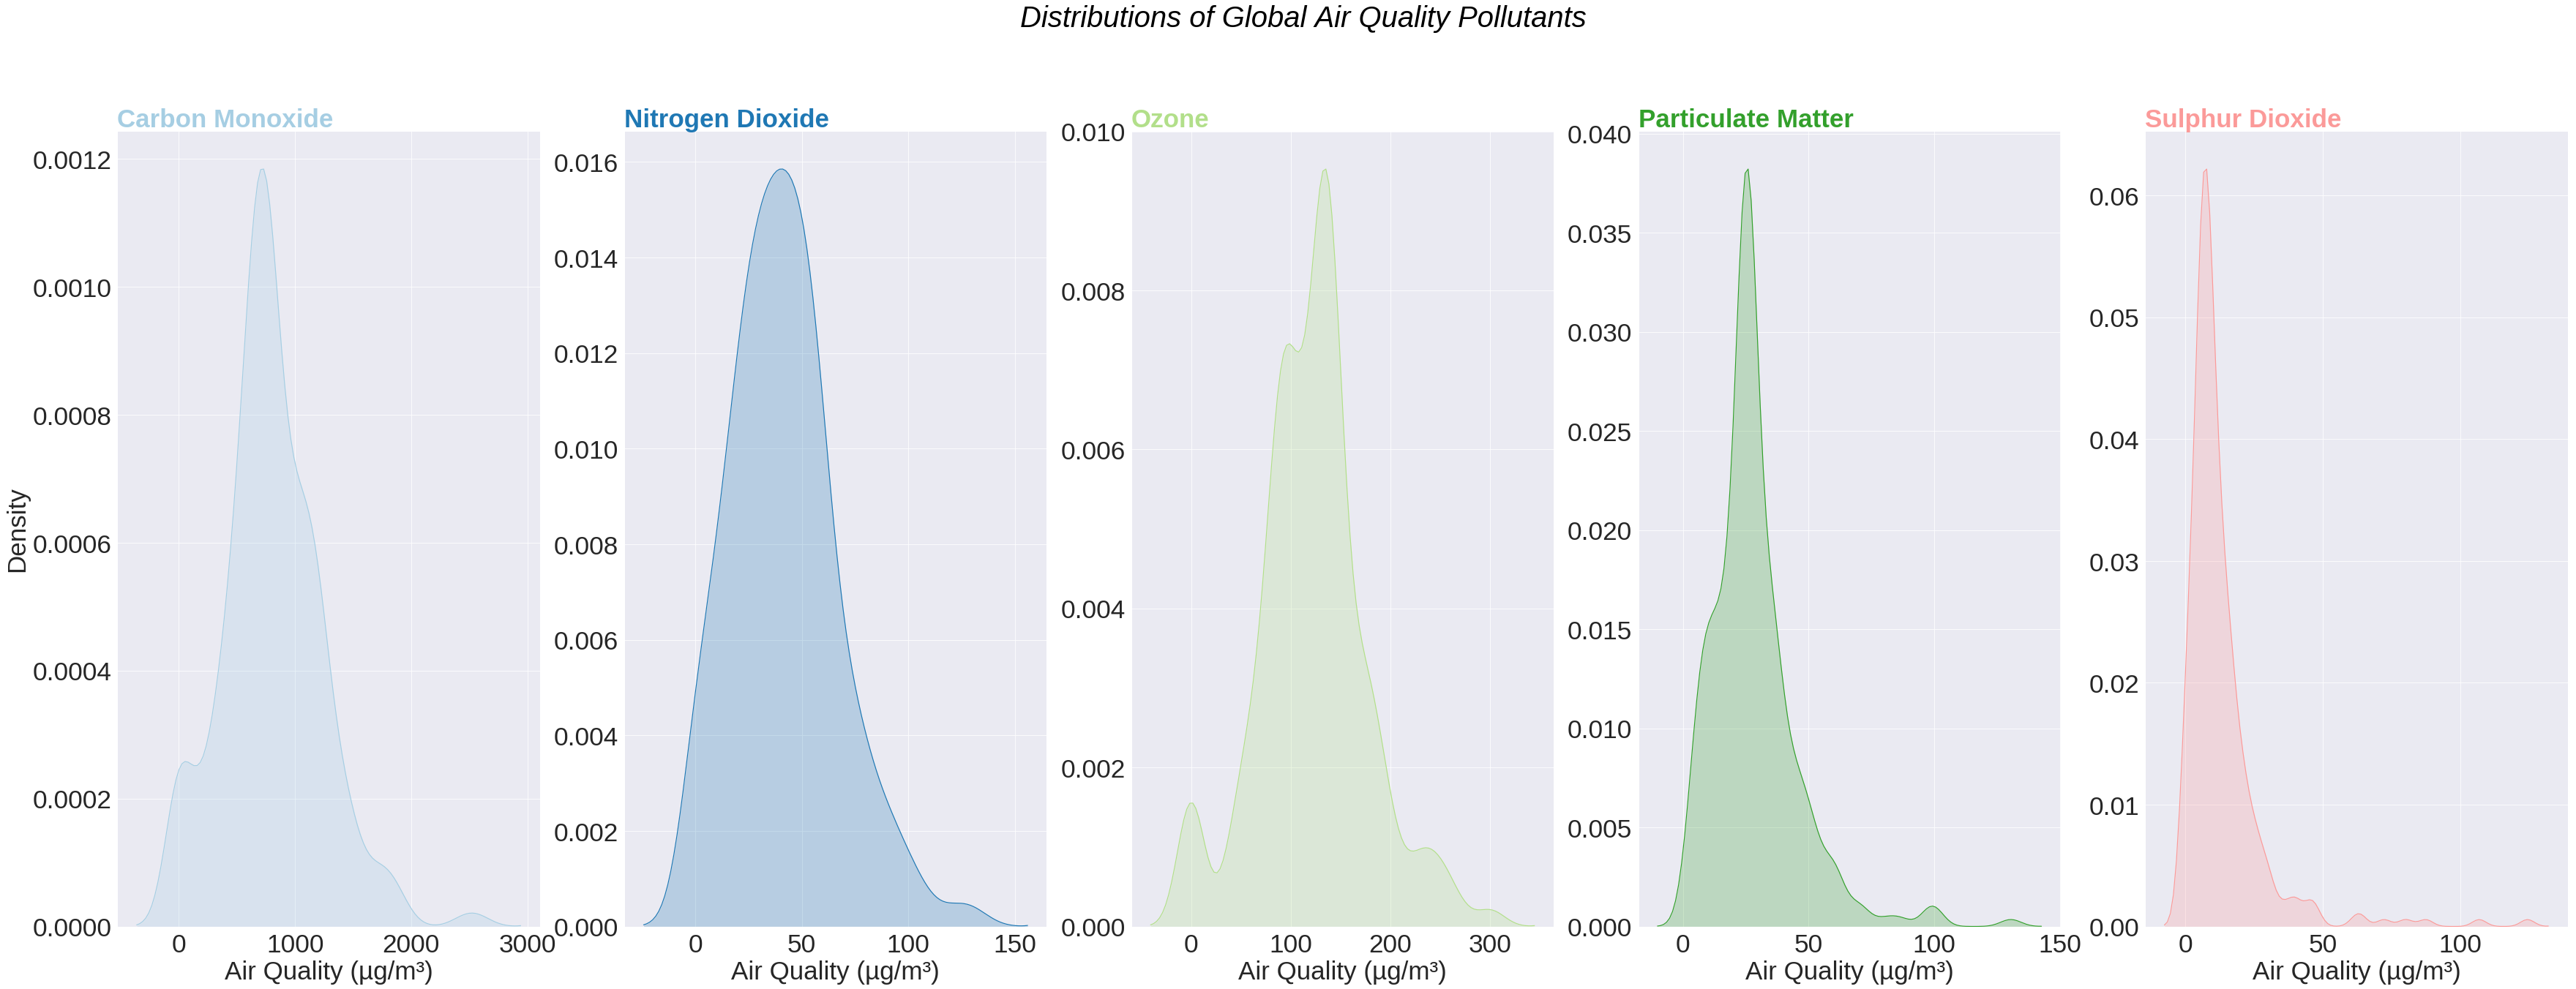

In [86]:
query_job="""
select
  *
from
  SANDBOX.global_air_quality_modeling_ds
"""

df_eda = client.query(query_job).result().to_dataframe()  # Waits for job to complete.
df_eda = df_eda[['MaxValue_co','MaxValue_no2','MaxValue_o3','MaxValue_pm25','MaxValue_so2']]

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Paired')
sns.set_context("paper", font_scale=4)

fig, axs = plt.subplots(1,5,figsize=(60,20))
# multiple line plot
num=0
for column in df_eda :
    num+=1 # Find the right spot on the plot
    plt.subplot(1,5, num)
    
    # plot every groups, but discreet
    sns.kdeplot(df_eda[column], shade=True, color=palette(num-1));
    plt.legend('')

    # Add title
    if num == df_eda.columns.get_loc("MaxValue_co")+1:
        plt.title("Carbon Monoxide", loc='left', fontsize=35, fontweight="bold", color=palette(num-1) )
        plt.ylabel("Density", fontsize=35)
    elif num == df_eda.columns.get_loc("MaxValue_no2")+1:
        plt.title("Nitrogen Dioxide", loc='left', fontsize=35, fontweight="bold", color=palette(num-1) )
        plt.ylabel("")
    elif num == df_eda.columns.get_loc("MaxValue_o3")+1:
        plt.title("Ozone", loc='left', fontsize=35, fontweight="bold", color=palette(num-1) )
        plt.ylabel("")
    elif num == df_eda.columns.get_loc("MaxValue_pm25")+1:
        plt.title("Particulate Matter", loc='left', fontsize=35, fontweight="bold", color=palette(num-1) )
        plt.ylabel("")
    else:
        plt.title("Sulphur Dioxide", loc='left', fontsize=35, fontweight="bold", color=palette(num-1) )
        plt.ylabel("")

    #fig.tight_layout()
    plt.xlabel("Air Quality (µg/m³)", fontsize=35)          
plt.suptitle("Distributions of Global Air Quality Pollutants", fontsize=40, fontweight=0, color='black', style='italic', y=1);

## Which are the most polluted cities?

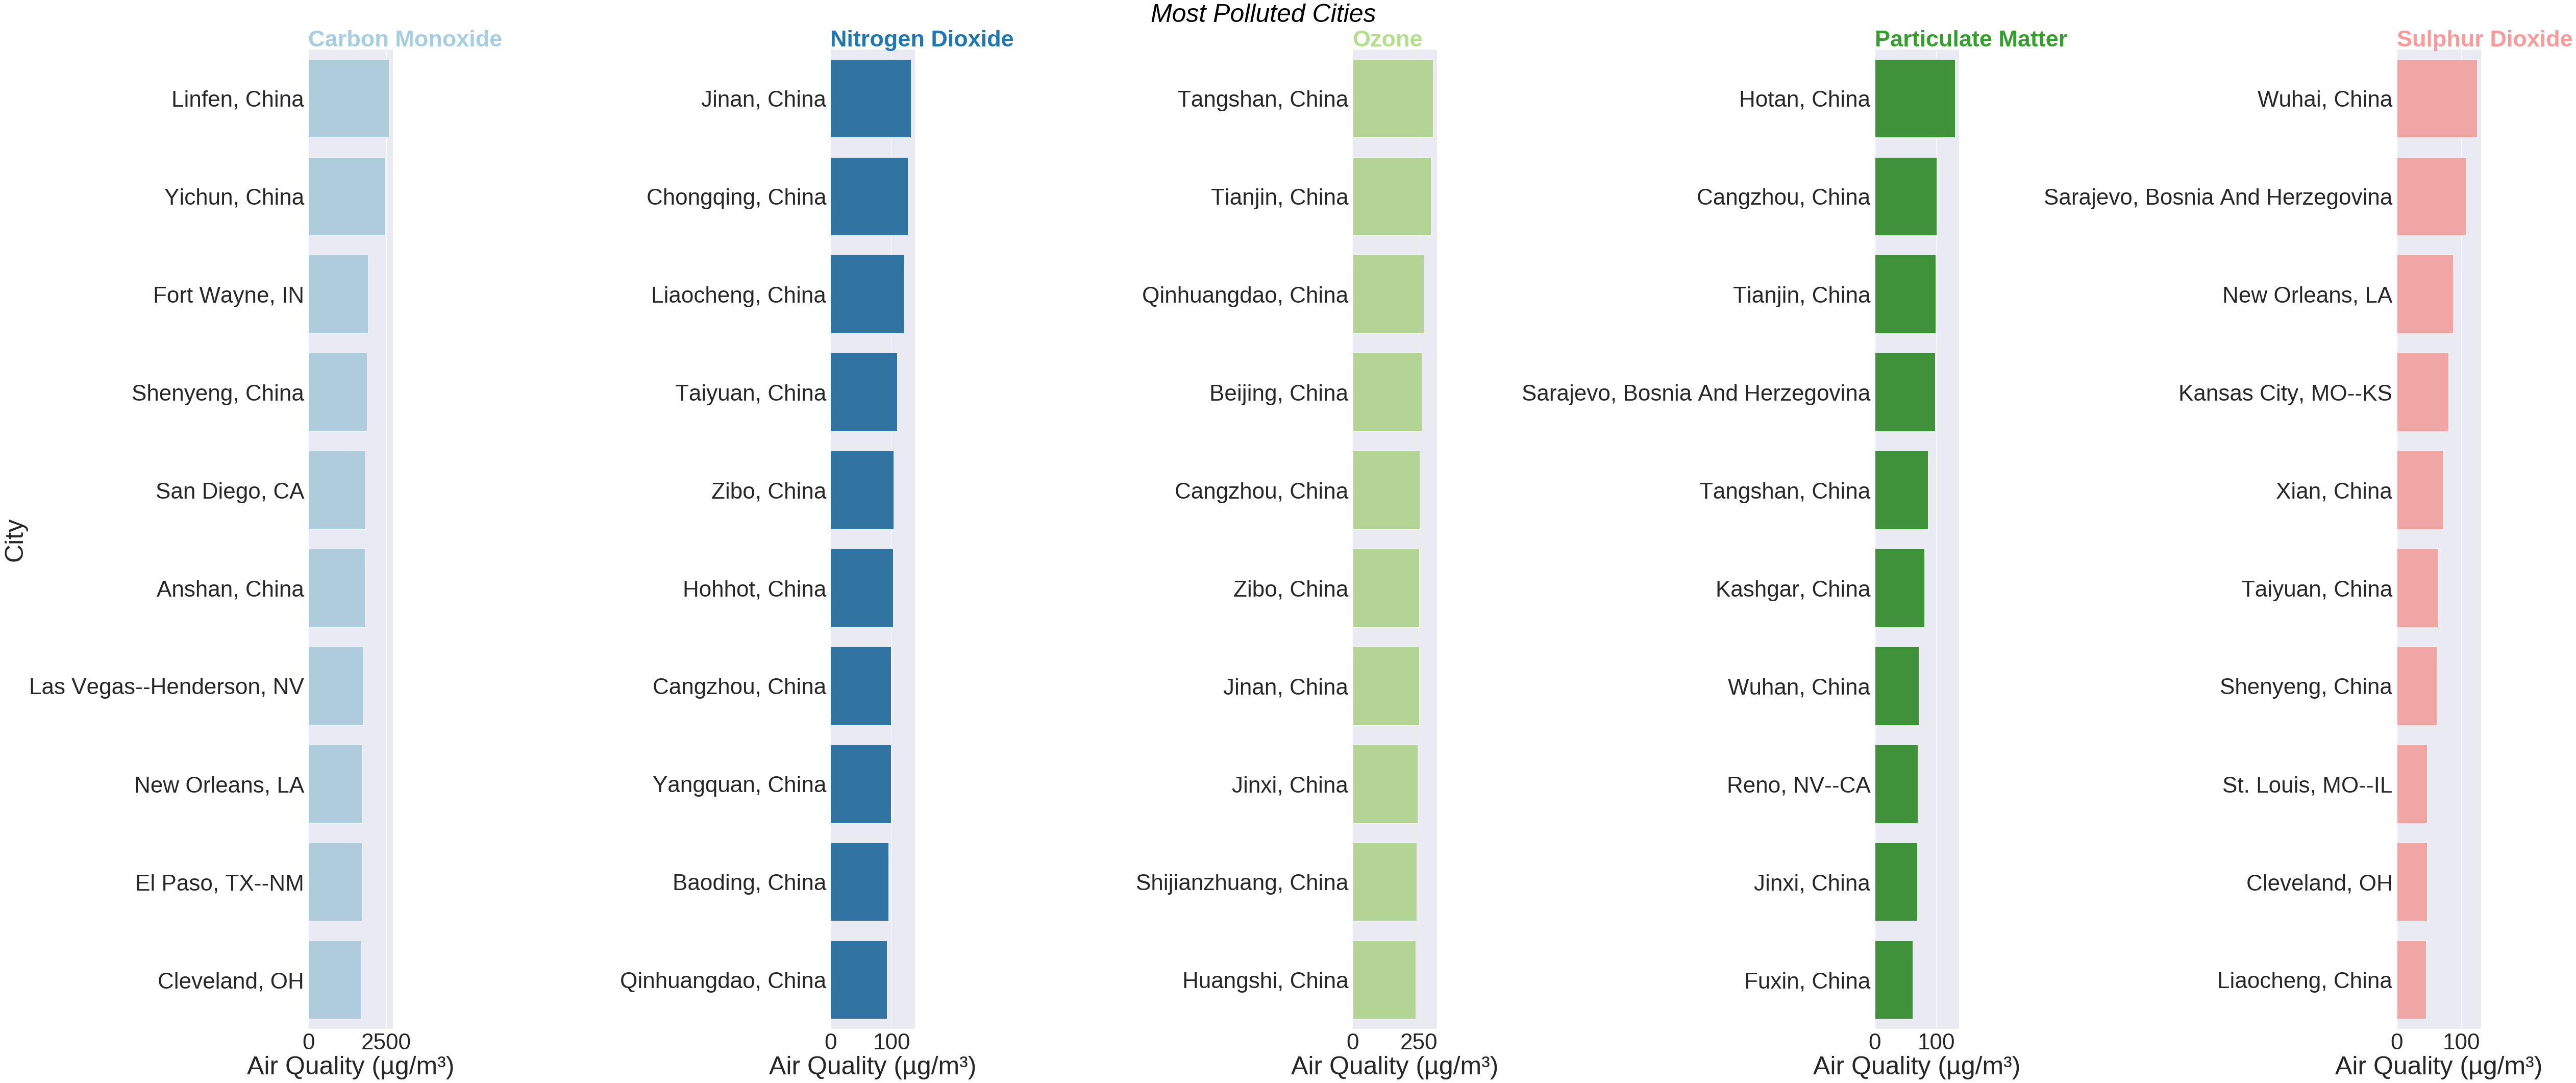

In [87]:
query_job="""
select
  *
from
  SANDBOX.global_air_quality_modeling_ds
"""

df_eda = client.query(query_job).result().to_dataframe()  # Waits for job to complete.
df_eda.loc[df_eda.country != 'United States', 'city'] = df_eda['city'] + ', ' + df_eda['country'] 
df_eda = df_eda[['city','MaxValue_co','MaxValue_no2','MaxValue_o3','MaxValue_pm25','MaxValue_so2']]
df_eda = df_eda.set_index('city')

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Paired')
sns.set_context("paper", font_scale=5)

#fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12,5))
fig, axs = plt.subplots(1,5,figsize=(70,30))

# multiple line plot
num=0
for column in df_eda :
    num+=1 # Find the right spot on the plot
    plt.subplot(1,5, num)

    df_eda = df_eda.sort_values(by=[column],ascending=False)
    df_haz = df_eda[:10]
    
    # plot every groups, but discreet
    sns.barplot(x = df_haz[column], y = df_haz.index, color = palette(num-1))

    # Add title
    if num == df_haz.columns.get_loc("MaxValue_co")+1:
        plt.title("Carbon Monoxide", loc='left', fontsize=45, fontweight="bold", color=palette(num-1) )
        plt.ylabel("City", fontsize=50)
    elif num == df_haz.columns.get_loc("MaxValue_no2")+1:
        plt.title("Nitrogen Dioxide", loc='left', fontsize=45, fontweight="bold", color=palette(num-1) )
        plt.ylabel("")
    elif num == df_haz.columns.get_loc("MaxValue_o3")+1:
        plt.title("Ozone", loc='left', fontsize=45, fontweight="bold", color=palette(num-1) )
        plt.ylabel("")
    elif num == df_haz.columns.get_loc("MaxValue_pm25")+1:
        plt.title("Particulate Matter", loc='left', fontsize=45, fontweight="bold", color=palette(num-1) )
        plt.ylabel("")
    else:
        plt.title("Sulphur Dioxide", loc='left', fontsize=45, fontweight="bold", color=palette(num-1) )
        plt.ylabel("")
    
    fig.tight_layout()

    plt.xlabel("Air Quality (µg/m³)", fontsize=50)          
plt.suptitle("Most Polluted Cities", fontsize=50, fontweight=0, color='black', style='italic', y=1);

## Correlation Plot

[Text(0, 0.5, 'Carbon Monoxide'),
 Text(0, 1.5, 'Nitrogen Dioxide'),
 Text(0, 2.5, 'Ozone'),
 Text(0, 3.5, 'Particulate Matter'),
 Text(0, 4.5, 'Sulphur Dioxide')]

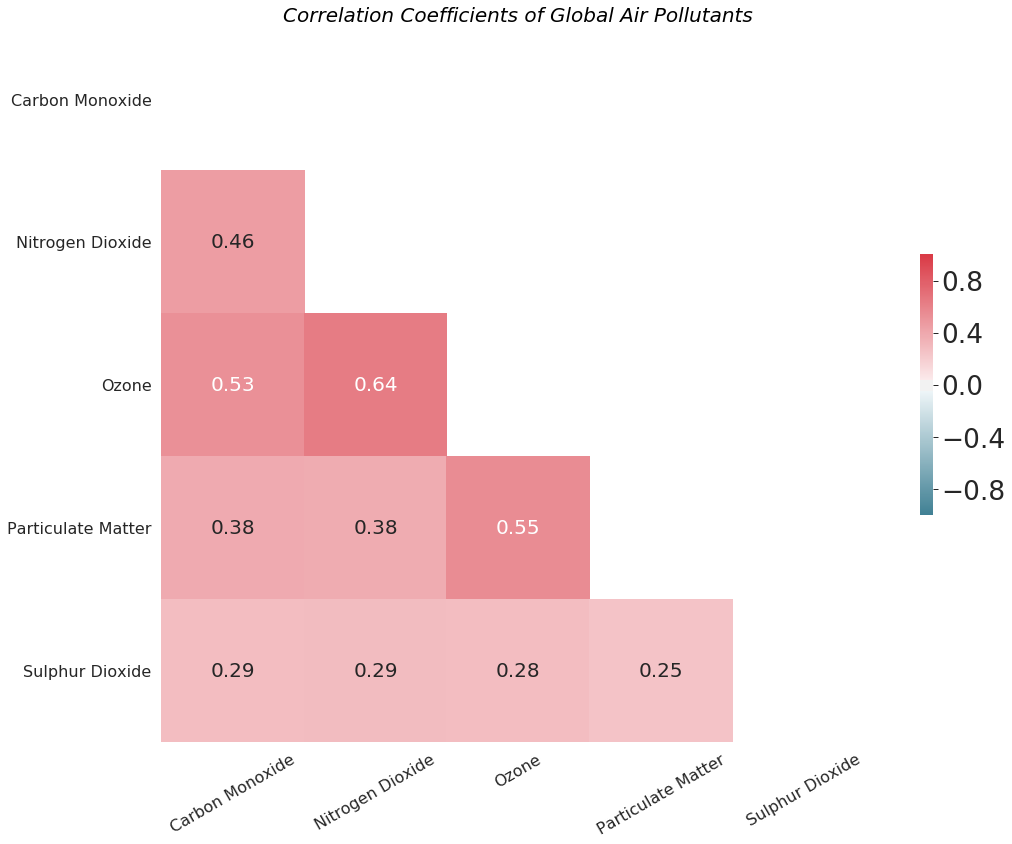

In [88]:
sns.set(style="white")

query_job="""
SELECT
    *
    FROM
    SANDBOX.global_air_quality_modeling_ds
"""
corr_df = client.query(query_job).result().to_dataframe()  # Waits for job to complete.
corr_df = corr_df[['MaxValue_co','MaxValue_no2','MaxValue_o3','MaxValue_pm25','MaxValue_so2']]
corr_df = corr_df.rename(columns={"MaxValue_co": "Carbon Monoxide",
                                  "MaxValue_no2": "Nitrogen Dioxide",
                                  "MaxValue_o3": "Ozone",
                                  "MaxValue_pm25": "Particulate Matter", 
                                  "MaxValue_so2": "Sulphur Dioxide"
                                  })

# Compute the correlation matrix
corr = corr_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure

f, ax = plt.subplots(figsize=(16, 16))


# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set_context("paper", font_scale=3)
#ax.tick_params(labelsize=16)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, annot=True, ax=ax,
            square=True, linewidths=0, cbar_kws={"shrink": .3}, annot_kws={"size": 20})

plt.title("Correlation Coefficients of Global Air Pollutants", fontsize=20, fontweight=0, color='black', style='italic', y=0.9);
#ax.xticks(rotation=45)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, fontsize = 16)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 16)

# K-Means Modeling 
First delete old cluster results

In [0]:
model_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
distance_type = ["EUCLIDEAN"]

for i in model_clusters:
    for j in distance_type:
        query_job = """
        DROP MODEL IF EXISTS
        SANDBOX.GLOBAL_AIR_QUALITY_KMEANS_{1}_{0}
        """.format(i, j)

        results = client.query(query_job).result()  # Waits for job to complete.

Run clustering algorithm from 2 to 10 clusters

In [0]:
model_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
distance_type = ["EUCLIDEAN"]

for i in model_clusters:
    for j in distance_type:
        query_job = """
        CREATE OR REPLACE MODEL
          SANDBOX.GLOBAL_AIR_QUALITY_KMEANS_{1}_{0}
        OPTIONS
          (model_type='kmeans',
            num_clusters={0},
            distance_type='{1}',
            standardize_features = TRUE) AS
        SELECT
          * EXCEPT(city,
                    country,
                    population,
                    lat,
                    lng,
                    pop_rank,
                    ValidAQ,
                    GeoPoint,
                    MaxValue_o3)
        FROM
          SANDBOX.global_air_quality_modeling_ds
        """.format(i, j)

        results = client.query(query_job).result()  # Waits for job to complete.

Retrieve the Davies Bouldin Index and Mean Squared Distance from the modeling results.
* Davies Bouldin Index: This measure, by definition has to account for Mi,j the separation between the ith and the jth cluster, which ideally has to be as large as possible, and Si, the within cluster scatter for cluster i, which has to be as low as possible. Hence the Davies–Bouldin index is defined as the ratio of Si and Mi,j. Due to the way it is defined, as a function of the ratio of the within cluster scatter, to the between cluster separation, a lower value will mean that the clustering is better. It happens to be the average similarity between each cluster and its most similar one, averaged over all the clusters, where the similarity is defined as Si above. This affirms the idea that no cluster has to be similar to another, and hence the best clustering scheme essentially minimizes the Davies–Bouldin index. This index thus defined is an average over all the i clusters, and hence a good measure of deciding how many clusters actually exists in the data is to plot it against the number of clusters it is calculated over. The number i for which this value is the lowest is a good measure of the number of clusters the data could be ideally classified into. This has applications in deciding the value of k in the kmeans algorithm, where the value of k is not known apriori.
* Mean Squared Distane: A measure of how well the centroids represent the members of their clusters is the residual sum of squares or RSS, the squared distance of each vector from its centroid summed over all vectors. RSS is the objective function in K-means and our goal is to minimize it. Since N$is fixed, minimizing RSS is equivalent to minimizing the average squared distance, a measure of how well centroids represent their documents.

In [0]:
model_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
distance_type = ["EUCLIDEAN"]
evaluate_models = pd.DataFrame()

for i in model_clusters:
    for j in distance_type:
        query_job = """
        SELECT
          {0} AS clusters,
          davies_bouldin_index,
          mean_squared_distance
        FROM
          ML.EVALUATE(MODEL SANDBOX.GLOBAL_AIR_QUALITY_KMEANS_{1}_{0})
        """.format(i, j)
        results = client.query(query_job).result().to_dataframe()  # Waits for job to complete.
        evaluate_models = evaluate_models.append(results, ignore_index=True)

#### Visualize the results in order to determine appropriate number of clusters according to the "Elbow Method":
1. Train the model on various cluster sizes (e.g. 2-15).
2. For both Davies Bouldin Index and Mean Squared Distance, lower values are better.
3. However, Mean Square Distance will converge to zero as clusters approach the number of data points.
4. Identify the number of clusters where the distance starts to plateau

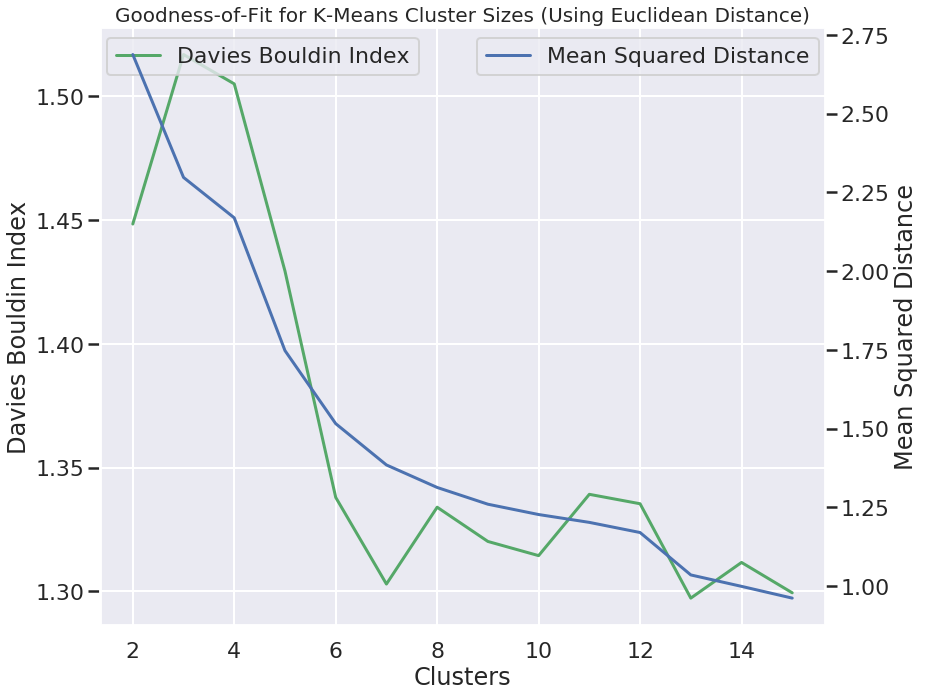

In [92]:
evaluate_models_euclidean = evaluate_models.sort_values(['clusters']).reset_index(drop=True)
sns.set()
sns.set_context(context='poster', font_scale=1)
plt.figure(figsize=(13, 11))
ax = sns.lineplot(y="davies_bouldin_index", x="clusters", data=evaluate_models_euclidean, color='g', label="Davies Bouldin Index")
ax.legend(loc = (.01, .92), frameon = True)
ax.set_xlabel("Clusters")
ax.set_ylabel("Davies Bouldin Index")
ax2 = plt.twinx()
ax = sns.lineplot(y="mean_squared_distance", x="clusters", data=evaluate_models_euclidean, color='b', label="Mean Squared Distance", ax = ax2)
ax2.set_ylabel("Mean Squared Distance")
ax2.legend(loc = (.52, .92), frameon = True)
ax2.set_title("Goodness-of-Fit for K-Means Cluster Sizes (Using Euclidean Distance)", fontsize=20)
ax2.grid(b=False) # turn off grid #2

### Silhouette Coefficient:
- The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample.
- The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.
- The Silhouette Coefficient for a sample is:
(b - a) / max(a, b)


In [0]:
model_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
distance_type = ["EUCLIDEAN"]
silhouette = pd.DataFrame()

for i in model_clusters:
    for j in distance_type:
        query_job = """
        SELECT
        {0} AS CLUSTER_SIZE,
        AVG(SILHOUETTE_SCORE) AS AVG_SILHOUETTE_SCORE
        FROM
        (SELECT
          city,
          country,
          CENTROID_ID,
          DISTANCE_A,
          NEXT_CENTROID_ID,
          DISTANCE_B,
          (DISTANCE_B-DISTANCE_A)/(CASE
              WHEN DISTANCE_A > DISTANCE_B THEN DISTANCE_A
            ELSE
            DISTANCE_B
          END) AS SILHOUETTE_SCORE
        FROM (
          SELECT
            OWN_CLUSTER.city,
            OWN_CLUSTER.country,
            OWN_CLUSTER.CENTROID_ID,
            OWN_CLUSTER.DISTANCE AS DISTANCE_A,
            NEAREST_CLUSTER.NEXT_CENTROID_ID AS NEXT_CENTROID_ID,
            NEAREST_CLUSTER.DISTANCE AS DISTANCE_B
          FROM (
            SELECT
              city,
              country,
              CENTROID_ID,
              NEXT_CENTROID_ID,
              DISTANCE
            FROM (
              SELECT
                A.city,
                A.country,
                A.CENTROID_ID,
                DISTANCE.CENTROID_ID AS NEXT_CENTROID_ID,
                DISTANCE.DISTANCE AS DISTANCE
              FROM (
                SELECT
                  CENTROID_ID,
                  nearest_centroids_distance,
                  city,
                  country
                FROM
                  ML.PREDICT( MODEL SANDBOX.GLOBAL_AIR_QUALITY_KMEANS_{1}_{0},
                    (
                    SELECT
                      *
                    FROM
                     SANDBOX.global_air_quality_modeling_ds))) A
              CROSS JOIN
                UNNEST(nearest_centroids_distance) AS DISTANCE)
            WHERE
              CENTROID_ID = NEXT_CENTROID_ID) OWN_CLUSTER,
            (
            SELECT
              city,
              country,
              CENTROID_ID,
              NEXT_CENTROID_ID,
              DISTANCE
            FROM (
              SELECT
                city,
                country,
                CENTROID_ID,
                NEXT_CENTROID_ID,
                DISTANCE,
                ROW_NUMBER() OVER (PARTITION BY city, country ORDER BY DISTANCE) AS ROW_N
              FROM (
                SELECT
                  A.city,
                  A.country,
                  A.CENTROID_ID,
                  DISTANCE.CENTROID_ID AS NEXT_CENTROID_ID,
                  DISTANCE.DISTANCE AS DISTANCE
                FROM (
                  SELECT
                    CENTROID_ID,
                    nearest_centroids_distance,
                    city,
                    country
                  FROM
                    ML.PREDICT( MODEL SANDBOX.GLOBAL_AIR_QUALITY_KMEANS_{1}_{0},
                      (
                      SELECT
                        *
                      FROM
                        SANDBOX.global_air_quality_modeling_ds))) A
                CROSS JOIN
                  UNNEST(nearest_centroids_distance) AS DISTANCE)
              WHERE
                CENTROID_ID != NEXT_CENTROID_ID )
            WHERE
              ROW_N=1) NEAREST_CLUSTER
          WHERE
        OWN_CLUSTER.city=NEAREST_CLUSTER.city 
        AND OWN_CLUSTER.country=NEAREST_CLUSTER.country))
        """.format(i, j)
        results = client.query(query_job).result().to_dataframe()  # Waits for job to complete.
        silhouette = silhouette.append(results, ignore_index=True)

Visualize the Silhouette Values

Text(0.5, 1.0, 'Average Silhouette Value for K-Means Cluster Sizes (Using Euclidean Distance)')

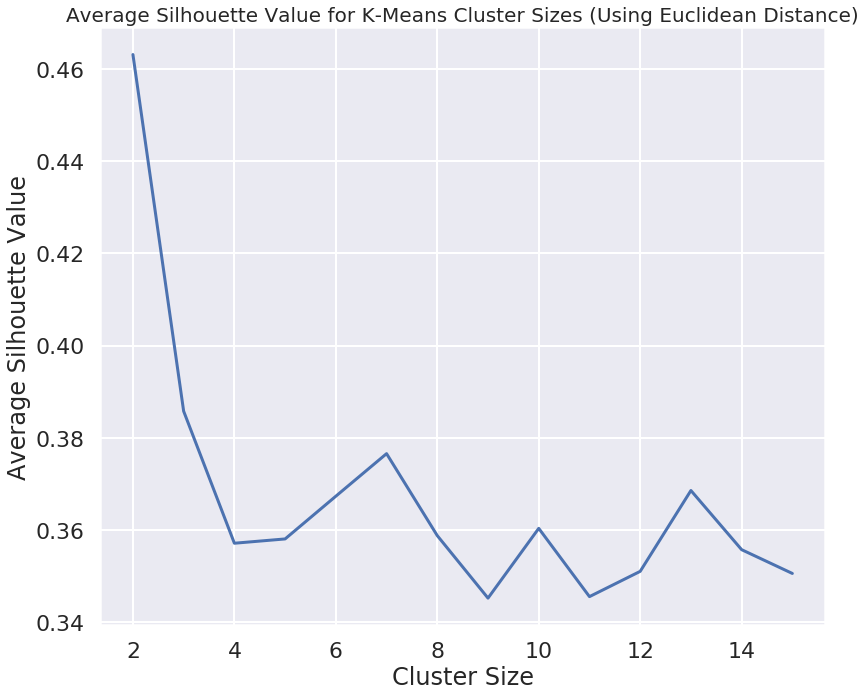

In [94]:
silhouette_euclidean = silhouette.sort_values(['CLUSTER_SIZE']).reset_index(drop=True)
sns.set()
sns.set_context(context='poster', font_scale=1)
plt.figure(figsize=(13, 11))
ax = sns.lineplot(y="AVG_SILHOUETTE_SCORE", x="CLUSTER_SIZE", data=silhouette_euclidean)

ax.set_xlabel("Cluster Size")
ax.set_ylabel("Average Silhouette Value")

ax.set_title("Average Silhouette Value for K-Means Cluster Sizes (Using Euclidean Distance)", fontsize=20)

Set the appropriate cluster size and review the centroids

In [96]:
model_type = 'EUCLIDEAN' #'EUCLIDEAN' or 'COSINE'
clusters = 7 #Modify for the optimal number of clusters

query_job="""
WITH T AS (
SELECT 
centroid_id,
ARRAY_AGG(STRUCT(feature AS name, ROUND(numerical_value,3) AS value) ORDER BY centroid_id) AS cluster
FROM ML.CENTROIDS(MODEL SANDBOX.GLOBAL_AIR_QUALITY_KMEANS_{0}_{1})
GROUP BY centroid_id
),
P AS (
SELECT 
centroid_id,
COUNT(DISTINCT concat(city, country)) as cities
FROM
  ML.PREDICT( MODEL SANDBOX.GLOBAL_AIR_QUALITY_KMEANS_{0}_{1},
    (
    SELECT
      *
    FROM
      SANDBOX.global_air_quality_modeling_ds))
    GROUP BY
    centroid_id)
SELECT
T.centroid_id,
P.cities,
(SELECT value from unnest(cluster) WHERE name = 'MaxValue_co') AS MaxValue_co,
(SELECT value from unnest(cluster) WHERE name = 'MaxValue_no2') AS MaxValue_no2,
--(SELECT value from unnest(cluster) WHERE name = 'MaxValue_o3') AS MaxValue_o3,
(SELECT value from unnest(cluster) WHERE name = 'MaxValue_pm25') AS MaxValue_pm25,
(SELECT value from unnest(cluster) WHERE name = 'MaxValue_so2') AS MaxValue_so2
FROM T 
LEFT JOIN
P
ON T.centroid_id=P.centroid_id
ORDER BY centroid_id ASC
""".format(model_type, clusters)
df_centroids = client.query(query_job).result().to_dataframe()  # Waits for job to complete.
df_centroids['MaxValue_Average'] = (df_centroids['MaxValue_co']+df_centroids['MaxValue_no2']+df_centroids['MaxValue_pm25']+df_centroids['MaxValue_so2'])/5 #+df_centroids['max_arithmetic_mean_so2']
df_centroids

,centroid_id,cities,MaxValue_co,MaxValue_no2,MaxValue_pm25,MaxValue_so2,MaxValue_Average
0,1,21,1580.843,62.241,26.376,16.202,337.1324
1,2,19,29.142,4.396,21.697,3.837,11.8144
2,3,60,881.871,26.355,31.423,9.818,189.8934
3,4,59,492.114,26.197,12.649,6.122,107.4164
4,5,16,1086.683,60.611,39.241,60.836,249.4742
5,6,32,1104.926,73.680,60.307,14.386,250.6598
6,7,73,782.119,52.945,25.120,12.886,174.6140


Visualize cluster centroids

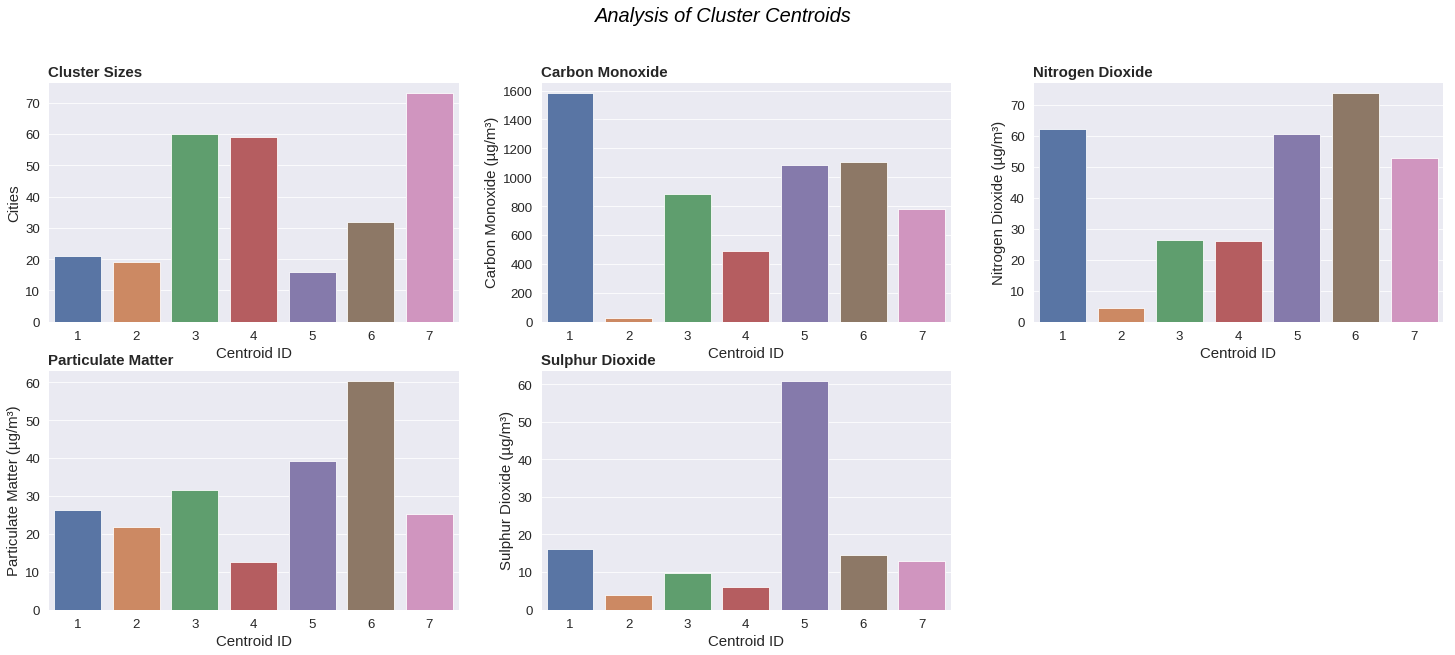

In [100]:
df_centroids_bars = df_centroids[['centroid_id','cities','MaxValue_co','MaxValue_no2','MaxValue_pm25','MaxValue_so2']]
df_centroids_bars = df_centroids_bars.set_index('centroid_id')

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Paired')
sns.set_context("paper", font_scale=1.5)

f, ax = plt.subplots(1,5,figsize=(25,15))
# multiple line plot
num=0
for column in df_centroids_bars :
    num+=1 # Find the right spot on the plot
    plt.subplot(3,3, num)
    
    # plot every groups, but discreet
    sns.barplot(x = df_centroids_bars.index, y = df_centroids_bars[column])

    # Add title
    if num == df_centroids_bars.columns.get_loc("MaxValue_co")+1:
        plt.title("Carbon Monoxide", loc='left', fontsize=15, fontweight="bold")
        plt.ylabel("Carbon Monoxide (µg/m³)", fontsize=15)
        plt.xlabel("Centroid ID", fontsize=15) 
    elif num == df_centroids_bars.columns.get_loc("MaxValue_no2")+1:
        plt.title("Nitrogen Dioxide", loc='left', fontsize=15, fontweight="bold")
        plt.ylabel("Nitrogen Dioxide (µg/m³)", fontsize=15)
        plt.xlabel("Centroid ID", fontsize=15) 
    #elif num == df_centroids_bars.columns.get_loc("MaxValue_o3")+1:
        #plt.title("Ozone", loc='left', fontsize=15, fontweight="bold")
        #plt.ylabel("Ozone (µg/m³)", fontsize=15)
        #plt.xlabel("Centroid ID", fontsize=15) 
    elif num == df_centroids_bars.columns.get_loc("MaxValue_pm25")+1:
        plt.title("Particulate Matter", loc='left', fontsize=15, fontweight="bold")
        plt.ylabel("Particulate Matter (µg/m³)", fontsize=15)
        plt.xlabel("Centroid ID", fontsize=15) 
    elif num == df_centroids_bars.columns.get_loc("MaxValue_so2")+1:
        plt.title("Sulphur Dioxide", loc='left', fontsize=15, fontweight="bold")
        plt.ylabel("Sulphur Dioxide (µg/m³)", fontsize=15)   
        plt.xlabel("Centroid ID", fontsize=15)
    else:
        plt.title("Cluster Sizes", loc='left', fontsize=15, fontweight="bold")
        plt.ylabel("Cities", fontsize=15)
        plt.xlabel("Centroid ID", fontsize=15) 

plt.suptitle("Analysis of Cluster Centroids", fontsize=20, fontweight=0, color='black', style='italic', y=0.95);

Set cluster assignments according to appropriate amount

In [0]:
query_job = """
CREATE OR REPLACE TABLE SANDBOX.cluster_assignments AS
SELECT 
* EXCEPT(nearest_centroids_distance)
FROM
  ML.PREDICT( MODEL SANDBOX.GLOBAL_AIR_QUALITY_KMEANS_{1}_{0},
    (
    SELECT
      *
    FROM
      SANDBOX.global_air_quality_modeling_ds))
""".format(clusters, model_type)

df_results = client.query(query_job).result()  # Waits for job to complete.

In [0]:
query_job = """
    select * from SANDBOX.cluster_assignments
    """
df_geo_clusters = client.query(query_job).result().to_dataframe()  # Waits for job to complete

In [0]:
def drop_map(df, size_feature, location, zoom, size_factor, map_size):
    drop_map = folium.Map(location = location, zoom_start = zoom, width = map_size, height = map_size)
    #print(pickup.shape)
    ### For each pickup point add a circlemarker
    
    for index, row in df[df['CENTROID_ID']==1].iterrows():

        folium.CircleMarker([row['lat'], row['lng']],
                            radius=row[size_feature]/size_factor,
                            color='blue', 
                            fill_opacity=0.5,
                            fill=True
                           ).add_to(drop_map)

    for index, row in df[df['CENTROID_ID']==2].iterrows():

        folium.CircleMarker([row['lat'], row['lng']],
                            radius=row[size_feature]/size_factor,
                            color='orange', #dark blue
                            fill_opacity=0.5,
                            fill=True
                           ).add_to(drop_map)

    template = """
    {% macro html(this, kwargs) %}

    <!doctype html>
    <html lang="en">
    <head>
      <meta charset="utf-8">
      <meta name="viewport" content="width=device-width, initial-scale=1">
      <title>jQuery UI Draggable - Default functionality</title>
      <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

      <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
      <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
      
      <script>
      $( function() {
        $( "#maplegend" ).draggable({
                        start: function (event, ui) {
                            $(this).css({
                                right: "auto",
                                top: "auto",
                                bottom: "auto"
                            });
                        }
                    });
    });

      </script>
    </head>
    <body>

    
    <div id='maplegend' class='maplegend' 
        style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
        border-radius:6px; padding: 10px; font-size:14px; right: 200px; bottom: 200px;'>
        
    <div class='legend-title'>Cluster</div>
    <div class='legend-scale'>
      <ul class='legend-labels'>
        <li><span style='background:blue;opacity:0.7;'></span>Cluster 1</li>
        <li><span style='background:orange;opacity:0.7;'></span>Cluster 2</li>

      </ul>
    </div>
    </div>
    
    </body>
    </html>

    <style type='text/css'>
      .maplegend .legend-title {
        text-align: left;
        margin-bottom: 5px;
        font-weight: bold;
        font-size: 90%;
        }
      .maplegend .legend-scale ul {
        margin: 0;
        margin-bottom: 5px;
        padding: 0;
        float: left;
        list-style: none;
        }
      .maplegend .legend-scale ul li {
        font-size: 80%;
        list-style: none;
        margin-left: 0;
        line-height: 18px;
        margin-bottom: 2px;
        }
      .maplegend ul.legend-labels li span {
        display: block;
        float: left;
        height: 16px;
        width: 30px;
        margin-right: 5px;
        margin-left: 0;
        border: 1px solid #999;
        }
      .maplegend .legend-source {
        font-size: 80%;
        color: #777;
        clear: both;
        }
      .maplegend a {
        color: #777;
        }
    </style>
    {% endmacro %}"""

    macro = MacroElement()
    macro._template = Template(template)

    drop_map.get_root().add_child(macro)

    return drop_map 

In [34]:
drop_map(df = df_geo_clusters, size_feature = 'population', location = [39,-94], zoom = 4, size_factor = 250000, map_size = '80%')

In [40]:
drop_map(df = df_geo_clusters, size_feature = 'population', location = [50,10], zoom = 4, size_factor = 250000, map_size = '80%')

In [41]:
drop_map(df = df_geo_clusters, size_feature = 'population', location = [30,120], zoom = 4, size_factor = 250000, map_size = '80%')